In [1]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
# import pytensor as pt
# import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit

import os


import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.special import expit, logsumexp
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
from numpyro.util import set_host_device_count
from numpyro.contrib.control_flow import scan
from numpyro.ops.indexing import Vindex
from tqdm import tqdm
from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
import pymc_experimental as pmx

import multiprocessing
import socket

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.4
Running on PyMC-experimental v0.0.17
Running on NumPyro v0.14.0
Running on Pyro v1.9.0+f02dfb9
Running on JAX v0.4.25


In [2]:
# Set CPU for JAX
# nchains = multiprocessing.cpu_count()/2
# print("nchains in total are", nchains*2, "; we'll use ", nchains)


# jax.config.update('jax_platform_name', 'cpu')
# platform = jax.lib.xla_bridge.get_backend().platform.casefold()
# print("Platform: ", platform)
# host_name = socket.gethostname()
# localhost_ = socket.gethostbyname(host_name)
# print(localhost_)

# jax.distributed.initialize(coordinator_address="localhost", num_processes=4, process_id=1)
# print(jax.device_count())
# print(jax.local_device_count())

# set_host_device_count(nchains)
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))




[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [3]:
RANDOM_SEED = 892357143
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

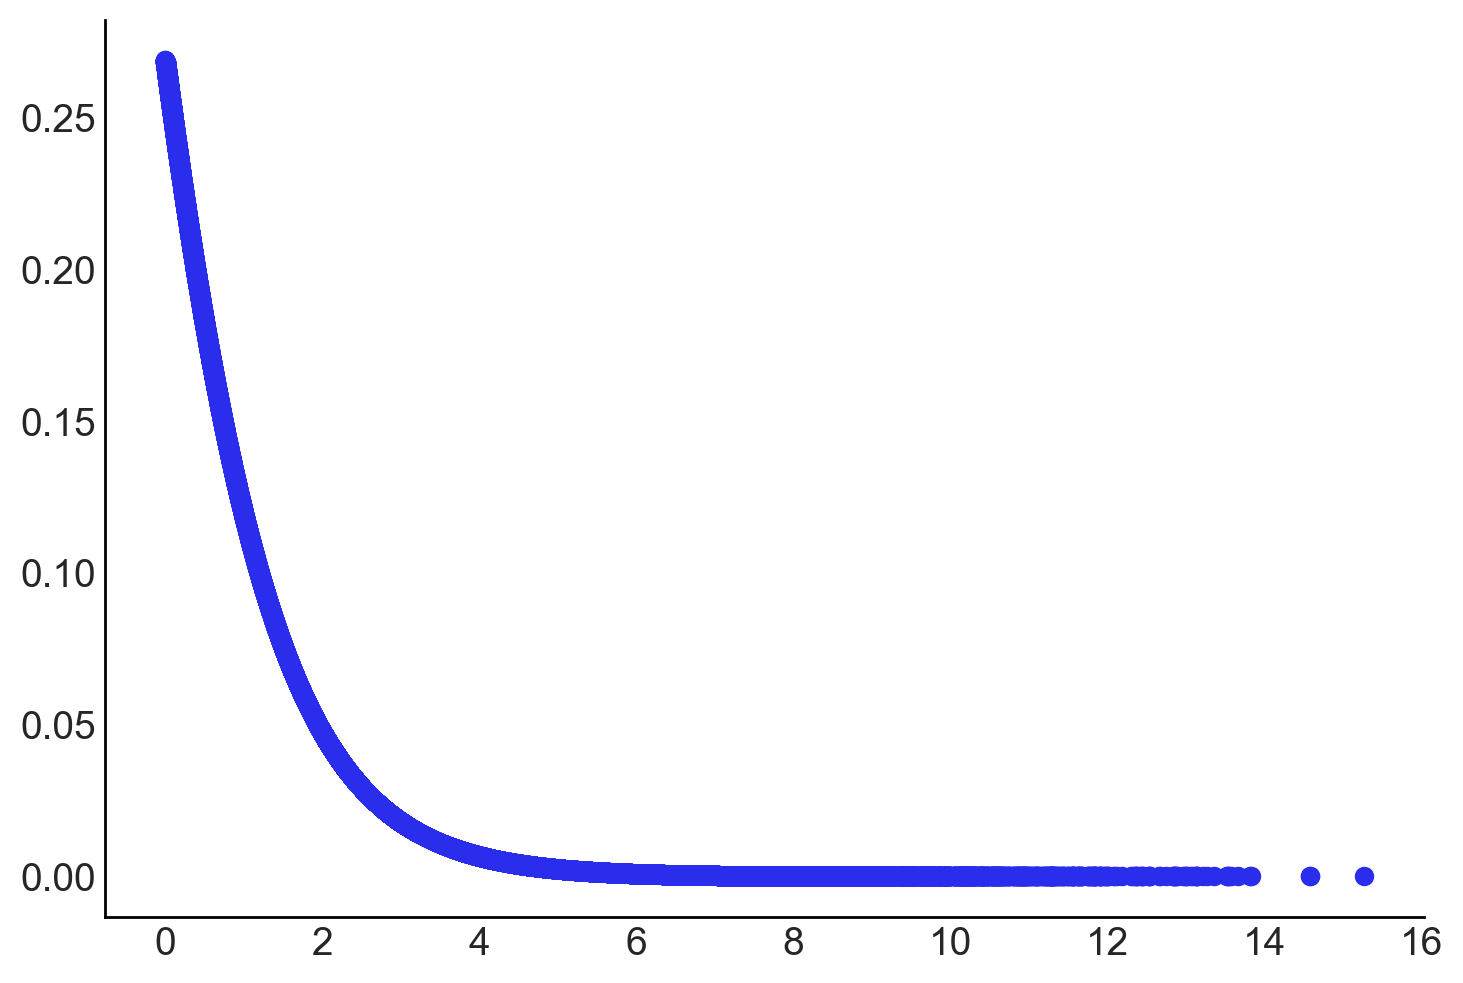

In [4]:
n=300
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
x2 = rng.binomial(n=1,p=0.25,size=n)

x_diff = []
x2_equal =[]
for i in range(n):
    for j in range(i+1,n):
        x_diff.append(np.abs(x[i]-x[j]))
        x2_equal.append(x2[i]==x2[j])
x_diff = np.array(x_diff)
x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
# beta = -2, -.5
beta = -1, -1
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
probs = expit(beta[0] + beta[1]*x_diff)

plt.scatter(x_diff,probs)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]



(array([ 8., 23., 20., 48., 37., 74., 59., 12., 14.,  5.]),
 array([ 0. ,  3.6,  7.2, 10.8, 14.4, 18. , 21.6, 25.2, 28.8, 32.4, 36. ]),
 <BarContainer object of 10 artists>)

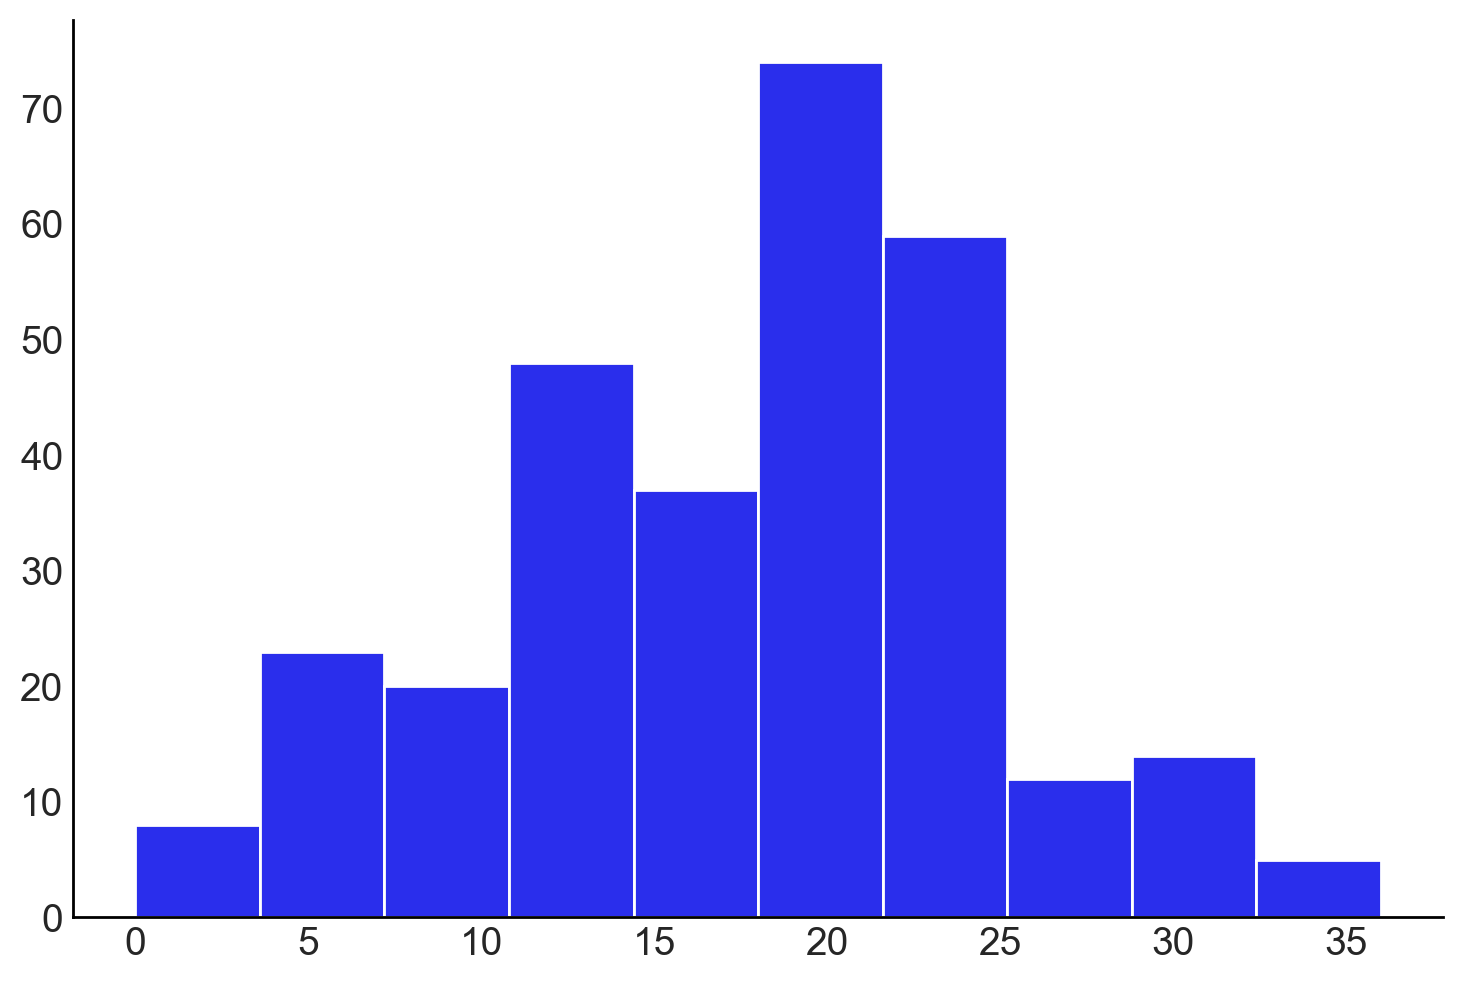

In [5]:
plt.hist(np.sum(mat,1))

                0
count  300.000000
mean     4.760000
std      2.851228
min      0.000000
25%      2.000000
50%      5.000000
75%      7.000000
max     13.000000


(array([ 8., 15., 34., 52., 58., 54., 43., 19., 14.,  3.]),
 array([-3.49827794e+00, -2.33187738e+00, -1.16547682e+00,  9.23738414e-04,
         1.16732430e+00,  2.33372486e+00,  3.50012542e+00,  4.66652598e+00,
         5.83292654e+00,  6.99932710e+00,  8.16572766e+00]),
 <BarContainer object of 10 artists>)

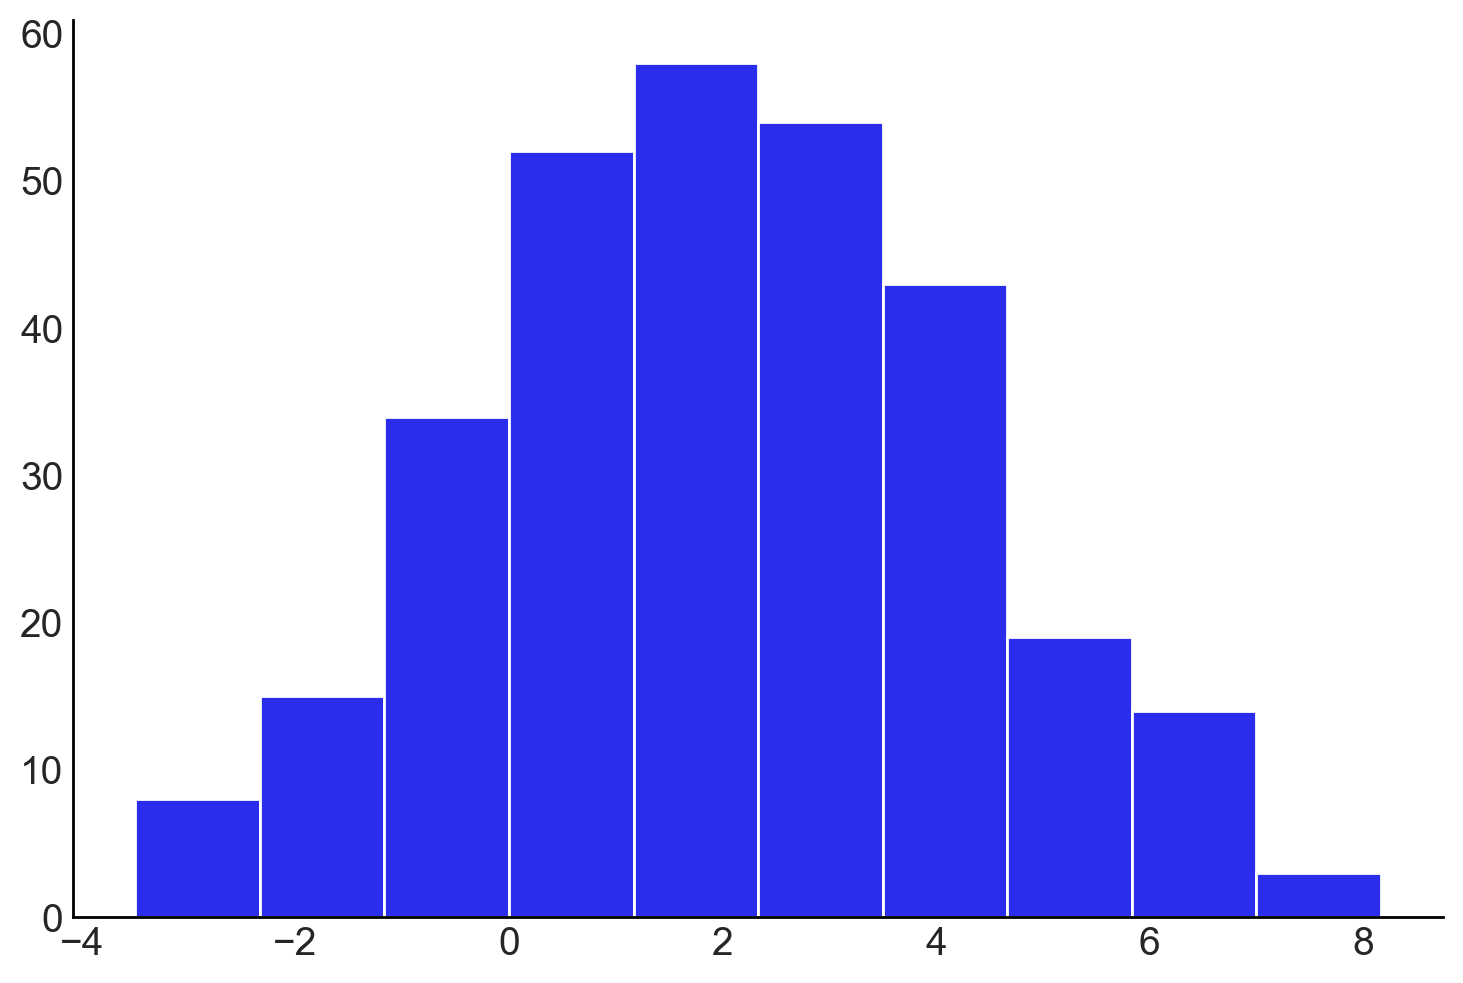

In [6]:
# Create outcome data

Z = rng.binomial(n=1,p=0.3,size=n)
# print(Z)
# print(np.dot(mat,Z)/np.sum(mat,1))
# print(np.dot(mat,Z))
# true_deg = np.sum(mat,1)
# exposures = np.dot(mat,Z)/np.sum(mat,1) > 0.5
# print(pd.DataFrame(exposures).value_counts())

# exposures = np.dot(mat,Z)
# exposures = np.dot(mat,Z)/np.sum(mat,1)

# sum_expos = np.dot(mat,Z)
deg = np.sum(mat,1)
# exposures = np.where(np.equal(deg,0), 0, sum_expos/deg)
exposures = np.dot(mat,Z) 
print(pd.DataFrame(exposures).describe())

# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
alpha = -1, 3, 0.5, -.25

# exposures = np.dot(mat,Z)
# Y = -0.5 + 1.5*Z + 3*exposures + 0.5*(exposures**2) + rng.normal(loc=0,scale=2,size=n)
# Y = -0.5 + 1.5*Z + 3*exposures + rng.normal(loc=0,scale=2,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*Z*exposures + rng.normal(loc=0,scale=3,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + rng.normal(loc=0,scale=3,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*exposures*Z + alpha[4]*true_deg + rng.normal(loc=0,scale=5,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*exposures*Z + alpha[4]*true_deg + rng.normal(loc=0,scale=1,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*true_deg + alpha[4]*x + rng.normal(loc=0,scale=1,size=n)
Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + rng.normal(loc=0,scale=1,size=n)

plt.hist(Y)


In [7]:
# DG = nx.from_numpy_array(mat)
# nx.set_node_attributes(DG, Z, "Treatments") 
# nx.draw(DG, with_labels=True,  node_color = Z)
# plt.legend()
# plt.show()

In [8]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
gamma0 = 0.05 # add non-existing edge with prob `bet` 

obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
for i in range(0,n): # add noise
    for j in range(i+1,n):
        if mat[i,j] == 1:
            obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
        else:
            obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
            
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


(array([ 3.,  9., 29., 44., 61., 66., 47., 28.,  8.,  5.]),
 array([10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. , 41.5, 45. ]),
 <BarContainer object of 10 artists>)

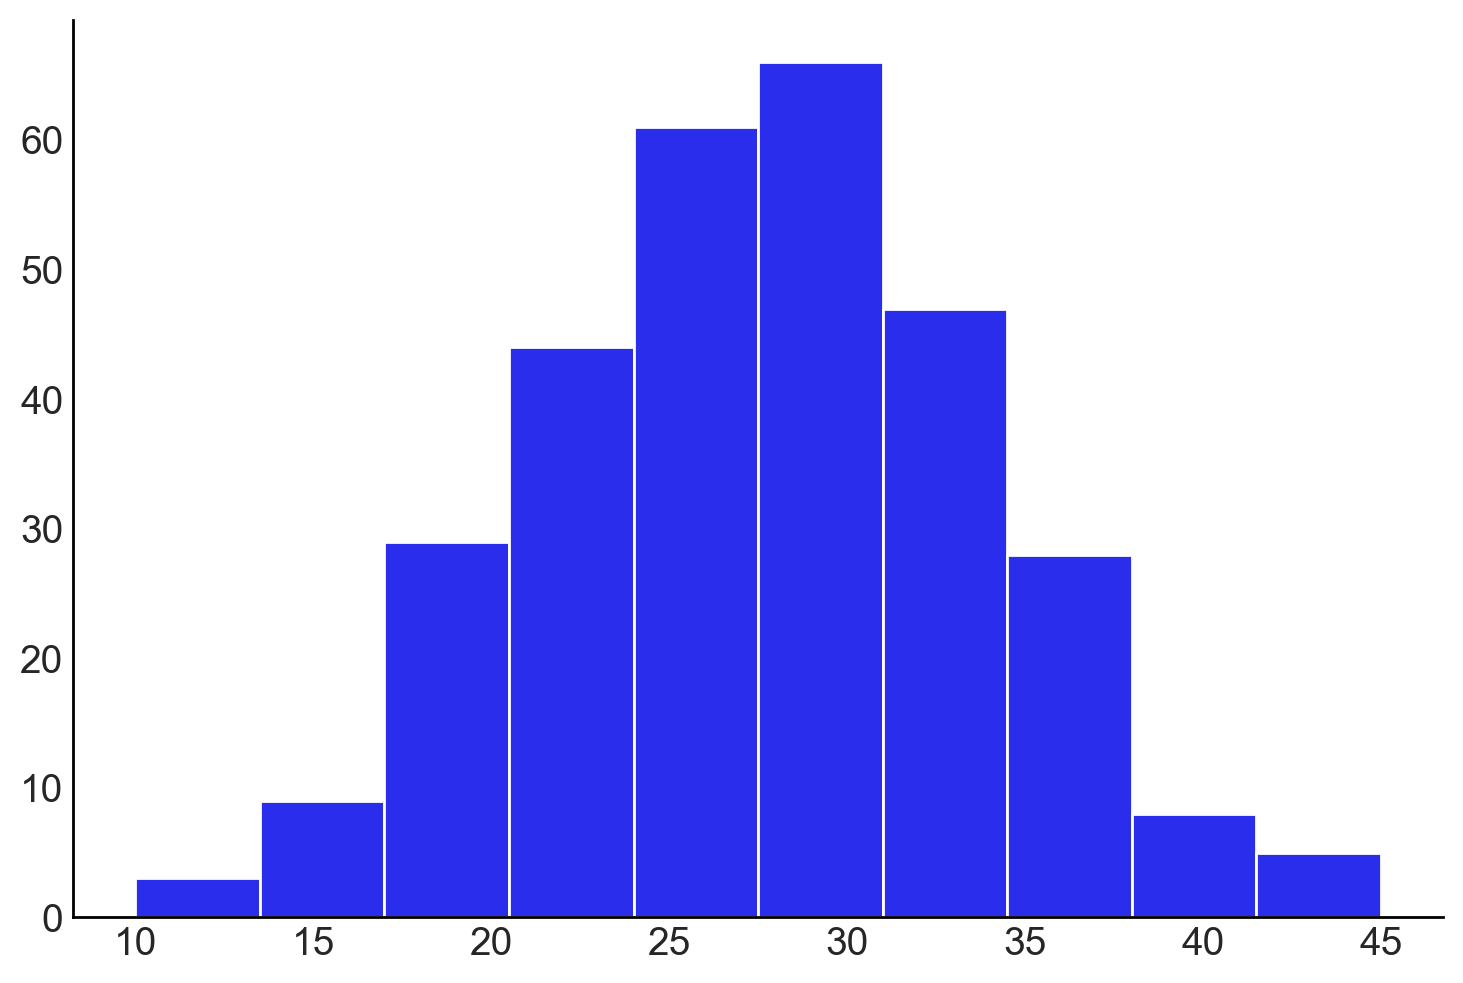

In [9]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.hist(np.sum(obs_mat,1))

In [10]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs'])


obs,0.0,1.0
true,,
0.0,40095,2125
1.0,644,1986


                0
count  300.000000
mean     7.070000
std      2.903999
min      1.000000
25%      5.000000
50%      7.000000
75%      9.000000
max     16.000000
Corr obs~true exposures:  0.7036530685300614


<Axes: >

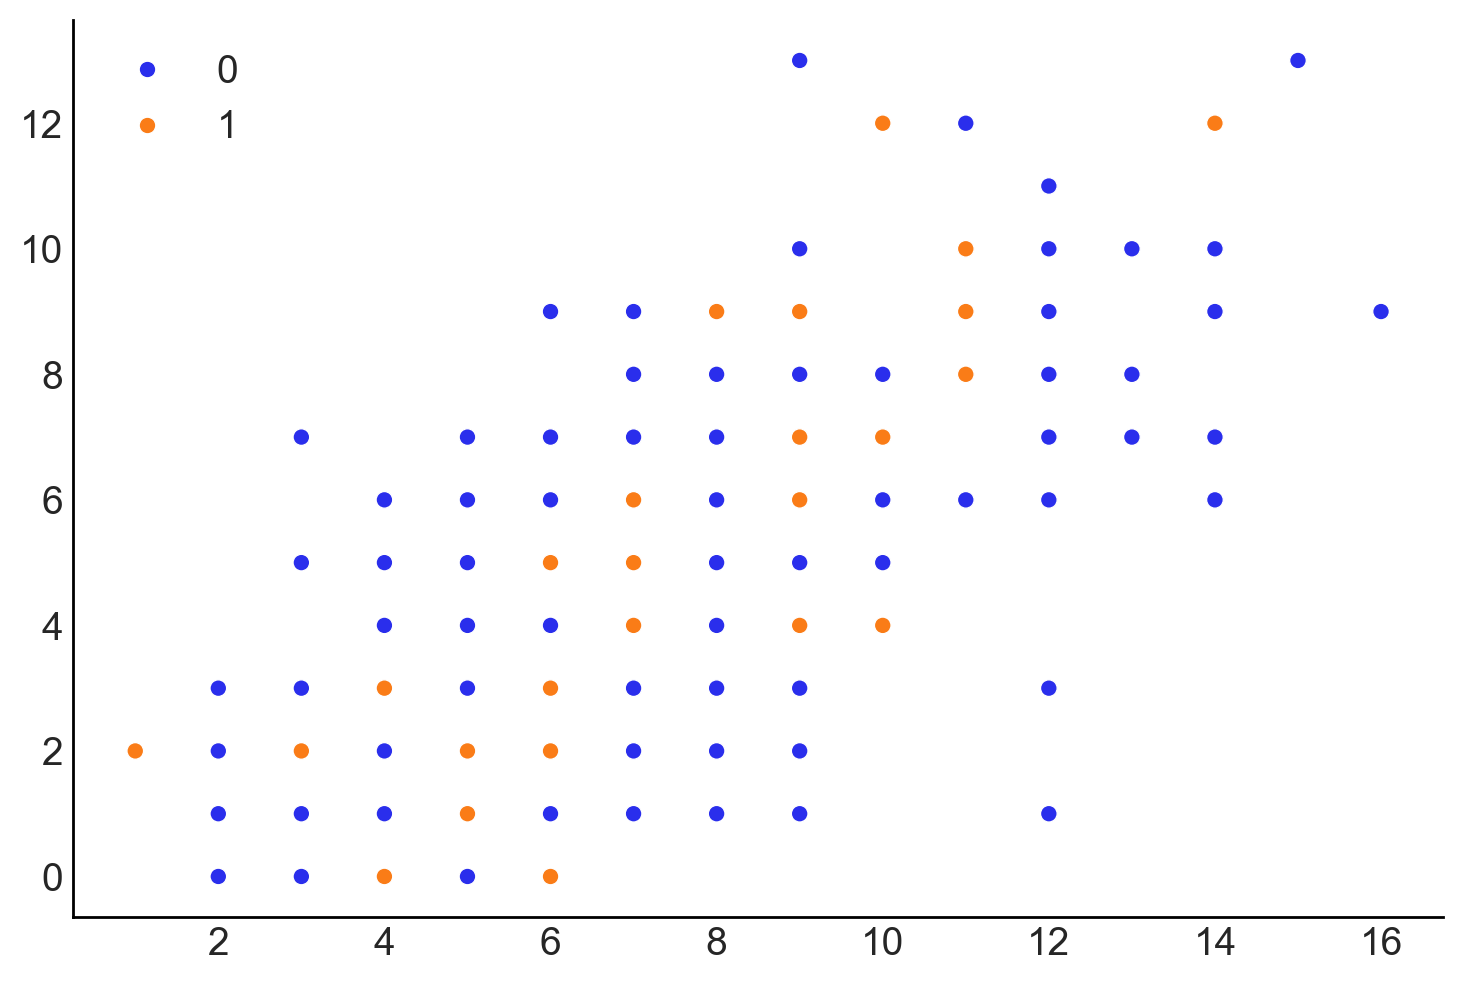

In [11]:

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)

# sum_expos_obs = np.dot(obs_mat,Z)
deg_obs = np.sum(obs_mat,1)
# obs_exposures = np.where(np.equal(deg_obs,0), 0, sum_expos_obs/deg_obs)
obs_exposures = np.dot(obs_mat,Z)

print(pd.DataFrame(obs_exposures).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
sns.scatterplot(x=obs_exposures,y=exposures, hue = Z)

In [12]:
# with pm.Model() as model_obs_mat:
#       # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     # obs_tril = pm.ConstantData("obs_tril", tril_obs)
#     obs_triu = pm.ConstantData("obs_triu", triu_obs)
#     expos = pm.ConstantData("expos", obs_exposures)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob, observed=obs_triu)
#     # tril = pm.Bernoulli("tril", p=prob, observed=obs_tril)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     mu_y = alpha0 + alpha1*z + alpha2*expos +  alpha3*z*expos 
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#       
# pm.model_to_graphviz(model_obs_mat)

In [13]:
# def triu_vals_to_mat(triu_vals, n):
#     # Z_val = Z.eval()
#     triu_vals_ = triu_vals.eval()
#     AM = np.zeros((n,n))
#     AM[np.triu_indices(n=n,k=1)] = triu_vals_
#     # AM[np.tril_indices(n=n,k=-1)] = tril_vals_
#     # AM = AM + AM.T 
#     return AM + AM.T 
#     # return np.dot(AM,Z_val)/np.sum(AM,1)
#     
# # def get_network_miss_prob(tril_vals, gamma0, gamma1):
# #     tril_vals = tril_vals.eval()
# #     obs_tril_prob = 
# 
# with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
#     
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     obs_triu = pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)
#     
#     # Generate net stats
#     A_mat = triu_vals_to_mat(triu,n)
#     expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     deg = pm.Deterministic("deg", pm.math.sum(A_mat,1))
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=5)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=5)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=5)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     sig_y = pm.Exponential("sig_y",lam=.5)
#     mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*deg
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# pm.model_to_graphviz(model)    

In [14]:
# with model:
#     step1 = pm.Metropolis([beta0, beta1, Gamma0, Gamma1, alpha0, alpha1, alpha2, alpha3, sig_y])
#     step2 = pm.BinaryMetropolis([triu])
#     MH_step = pm.CompoundStep([step2, step1])
#     trace = pm.sample(draws=5000, tune=3000, chains=4, cores=4, step=MH_step)
#     # trace = pm.sample(draws=4000, tune=2000, chains=4, cores=4)
#     

In [15]:
# az.summary(trace)

In [16]:
# az.plot_trace(trace)


In [17]:
# with pmx.MarginalModel() as marg_model:      
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     # z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     # y = pm.ConstantData("Y_",Y)
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)  
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)   
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)    
#     # logit model of edges
#     # mu = beta0 + beta1*x + u 
#     # prob = pm.math.invlogit(mu)
#     # Ltri_A_mat = pm.Bernoulli("
#     
#     # Get exposures
#     # expos = tril_vals_to_exposures(obs_tril, z, n)
#     # Lower tri to adj. matrix
#     # A_mat = tril_vals_to_mat(obs_tril,n)
#     # A_mat = triu_vals_to_mat(triu,n)
#     # degress = pm.math.sum(A_mat,1)
#     # sum_expos = pm.math.dot(A_mat,z)
#     # expos = pm.Deterministic("expos", pm.math.switch(pt.tensor.eq(degress,0),0,sum_expos/degress))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z)/pm.math.sum(A_mat,1))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     # # Outcome model
#     # alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     # alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     # alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     # alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     # # alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     # sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*(expos**2)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*z*expos 
#     # Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# marg_model.marginalize(["triu"])
# pm.model_to_graphviz(marg_model)    

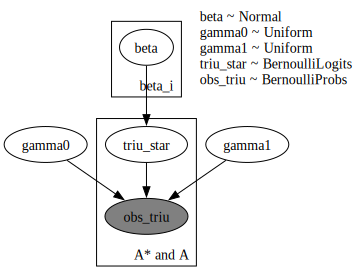

In [12]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_utri = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_utri].set(triu) 
    return adj_mat + adj_mat.T

@config_enumerate
def network_model(X, TriU, n):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,10))
    mu_net = beta[0] + beta[1]*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", triu_n):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 


def outcome_model(Y,Z,X,A,n):
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # sig = numpyro.sample("sig",dist.HalfNormal(scale=5))
    sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("n",n):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)

# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff,triu_obs,n), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))
# TODO: Check different samplers in NumPyro (e.g., HMCwithGibbs, M-HMC, marginalization); They are probably slow, check their runtime and ESS (e.g., in comparison to PyMC).
# TODO: Replace `for` loop with `enumerate`; use `scan` function (see NumPyro HMM guide https://num.pyro.ai/en/stable/examples/hmm_enum.html) see also https://pyro.ai/examples/enumeration.html
# TODO: see also this numpyro guidebook (``rethinking") https://fehiepsi.github.io/rethinking-numpyro/

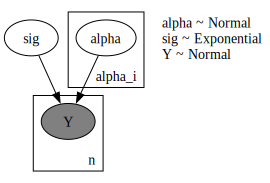

In [13]:
numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)

In [14]:
# A* and A|A* models

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model, dense_mass=True)
kernel_network = NUTS(network_model)
mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -1.01      0.29     -1.04     -1.44     -0.56   3976.76      1.00
   beta[1]     -1.09      0.08     -1.08     -1.22     -0.96   4904.79      1.00
    gamma0      0.05      0.00      0.05      0.05      0.06   5649.70      1.00
    gamma1      0.25      0.14      0.25      0.05      0.50   4188.66      1.00

Number of divergences: 0
436.0578918457031


In [15]:
# Outcome model with A* (true network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.02      0.12     -1.02     -1.22     -0.83   9218.50      1.00
  alpha[1]      2.98      0.14      2.98      2.75      3.20  12632.22      1.00
  alpha[2]      0.49      0.02      0.48      0.45      0.52   9595.75      1.00
  alpha[3]     -0.26      0.02     -0.26     -0.29     -0.22  13733.38      1.00
       sig      1.03      0.04      1.03      0.97      1.10  13820.27      1.00

Number of divergences: 0
5.50403094291687


In [16]:
# Outcome model with A (observed network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.97      0.23     -0.97     -1.34     -0.57   9546.84      1.00
  alpha[1]      3.05      0.20      3.05      2.73      3.37  14823.03      1.00
  alpha[2]      0.32      0.03      0.32      0.27      0.36  10092.90      1.00
  alpha[3]     -0.25      0.03     -0.25     -0.30     -0.20  17004.95      1.00
       sig      1.47      0.06      1.47      1.37      1.56  16517.13      1.00

Number of divergences: 0
5.271262168884277


In [17]:
print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

['beta_0 = -1', 'beta_1 = -1'] gamma0: 0.05 gamma1: 0.25
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [18]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)
a_star_pred = Predictive(model=network_model, posterior_samples=post_pred_mean, infer_discrete=True,num_samples=1)
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

(16000, 2)
(16000,)
{'beta': Array([[-1.0087905, -1.087858 ]], dtype=float32), 'gamma0': Array([0.05443469], dtype=float32), 'gamma1': Array([0.2514589], dtype=float32)}
(1, 44850)
(1, 44850)
False


sec,0,1
first,,
0,41150,1259
1,1268,1173


In [19]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
post_predictive = post_predictive(rng_key, X=x_diff,TriU=triu_obs,n=n)
samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

(16000, 44850)
(44850,)


In [20]:
NN = n

@jax.jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T

#     AM = np.zeros((NN,NN))
#     AM[np.triu_indices(n=NN,k=1)] = triu_v
#     return AM + AM.T 
# 
# 
# print(np.triu_indices(n=NN,k=1))
# print(a_star_pred1["triu_star"].shape)
# print(a_star_pred1["triu_star"][0])
# 
# st = time.time()
# for i in range(10000):
#     A1 = triu_to_mat(a_star_pred1["triu_star"], n)
# print("Regular takes: ", time.time() - st)

st = time.time()
for i in range(100):
    A2 = Triu_to_mat(a_star_pred1["triu_star"][0])
print("jax.jit takes: ", time.time() - st)

# print(np.array_equal(A1,A2))


jax.jit takes:  0.20783329010009766


(300, 300)
True expos~Y corr: 0.6112175267930011
Pred1 expos~Y corr: 0.4864633210057643
Pred2 expos~Y corr: 0.49410561065416364
obs expos~Y corr: 0.39103408750581764


Text(0, 0.5, 'True')

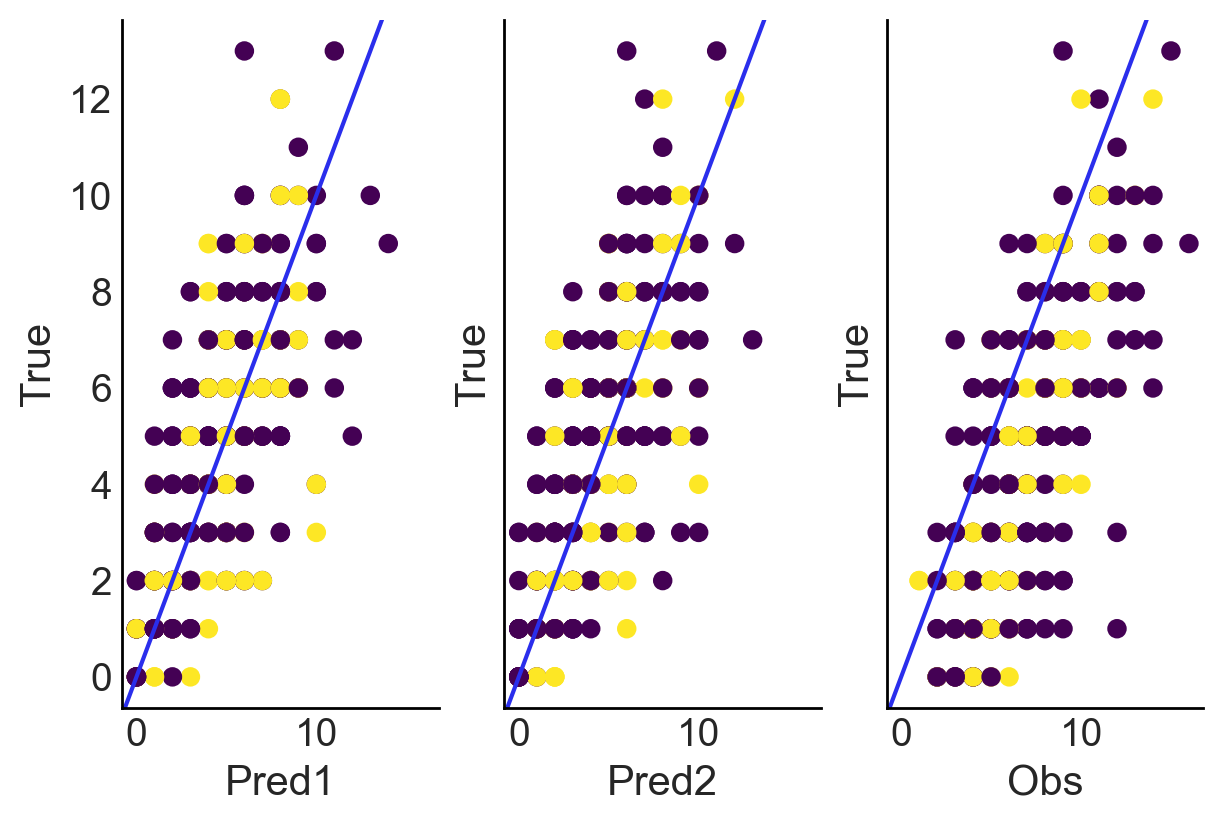

In [21]:

A_star_pred = Triu_to_mat(a_star_pred1["triu_star"][0])
A_star_pred2 = Triu_to_mat(a_star_pred2["triu_star"][0])
# A_star_pred = triu_to_mat(a_star_pred1["triu_star"],n)
# A_star_pred2 = triu_to_mat(a_star_pred2["triu_star"],n)
print(A_star_pred.shape)
# print(A_star_pred)


a_star_pred_deg = np.sum(A_star_pred,1)
a_star_pred_deg2 = np.sum(A_star_pred2,1)
a_star_sum_expos = np.dot(A_star_pred,Z) 
a_star_sum_expos2 = np.dot(A_star_pred2,Z)

Pred_expos1 = np.where(np.equal(a_star_pred_deg,0),0,a_star_sum_expos/a_star_pred_deg)
Pred_expos2 = np.where(np.equal(a_star_pred_deg2,0),0,a_star_sum_expos2/a_star_pred_deg2)

print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])
print("Pred1 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos)[1,0])
print("Pred2 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos2)[1,0])
print("obs expos~Y corr:",np.corrcoef(Y,obs_exposures)[1,0])


fig, axes = plt.subplots(nrows=1,ncols=3, sharex=True, sharey=True, figsize = (6,4))
ax1, ax2, ax3 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(a_star_sum_expos, exposures,c = Z+1, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(a_star_sum_expos2, exposures,c = Z+1, marker = 'o')
ax2.axline((0,0),slope=1)
ax3.scatter(obs_exposures, exposures,c = Z+1, marker = 'o')
ax3.axline((0,0),slope=1)
ax1.set_xlabel("Pred1")
ax2.set_xlabel("Pred2")
ax3.set_xlabel("Obs")
ax1.set_ylabel("True")
ax2.set_ylabel("True")
ax3.set_ylabel("True")
# ax.axline((0,0),slope=1)
# ax.set_xlabel("Obs")
# ax.set_ylabel("True")
# plt.show()

In [22]:
# Two-stage with mean posterior of A* and A|A* parameters
def twostage_estimator(MCMC_obj, a_star_pred, Y, Z, X, x_diff, triu_obs, n,i):
    
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=n)
    # curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
    curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
   
    # pred_exp = np.dot(curr_Astar, Z)
    # print("Pred expos~Y corr:",np.corrcoef(Y,pred_exp)[1,0])
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i**2),Y=Y,Z=Z,X=X, A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()
    
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
    # return xr.DataArray(converted_post_samp)


NN = n

@jax.jit
def get_samples(key, Y, Z, X, A ,n_warmup=500, n_samples=250, n_chains=2):
    kernel_outcome = NUTS(outcome_model)
    mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False)
    mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    return mcmc.get_samples()

def twostage_jj(a_star_pred, Y, Z, X, x_diff, triu_obs, i):
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=NN)
    # curr_Astar = triu_to_mat(curr_Astar["triu_star"],NN)
    curr_Astar = Triu_to_mat(curr_Astar["triu_star"][0])
    # Run MCMC
    curr_posterior_samples = get_samples(random.PRNGKey(i**2), Y, Z, X, curr_Astar)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
     
     
kernel_outcome = NUTS(outcome_model)
mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred_jit = MCMC(kernel_outcome, num_warmup=250, num_samples=500,num_chains=1, progress_bar=False, jit_model_args=True)
# twostage_post_samp = Parallel(n_jobs=4)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n, 100))
print("starting parallel")
print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])

# # 
# start = time.time()
# twostage_post_samp = Parallel(n_jobs=8)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x, x_diff, triu_obs, n,i) for i in tqdm(range(10)))
# # twostage_post_samp = xr.merge(twostage_post_samp)
# twostage_post_samp = pd.concat(twostage_post_samp,axis=0)
# print(twostage_post_samp)
# print("No JIT takes: ", time.time() - start)


start = time.time()
twostage_post_samp_jit = pd.DataFrame()
# for i in tqdm(range(50)):
for i in tqdm(range(50)):
    cur_res = twostage_jj(a_star_pred, Y, Z, x, x_diff, triu_obs,i)
    twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
print(twostage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)



# print(time.time() - start)
# print("starting sequential")
# start = time.time()
# twostage_post_samp2 = [twostage_estimator(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n,i) for i in tqdm(range(20))]
# twostage_post_samp2 = pd.concat(twostage_post_samp2,axis=0)
# print(time.time() - start)

# print(twostage_post_samp)
# print(twostage_post_samp.shape)
# print(twostage_post_samp2)
# print(twostage_post_samp2.shape)

starting parallel
True expos~Y corr: 0.6112175267930011


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\jax\_src\interpreters\pxla.py:1797: UserWarning: The jitted function get_samples includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(
100%|██████████| 50/50 [00:11<00:00,  4.24it/s]

     iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
0       0  1.331305 -0.395723  2.938069  0.362913 -0.286830
1       0  1.464907 -0.494472  2.881307  0.387102 -0.281456
2       0  1.279574 -0.093034  2.832443  0.327487 -0.245886
3       0  1.496001 -0.270097  2.806130  0.349044 -0.287079
4       0  1.382618 -0.269371  2.499926  0.368390 -0.266093
..    ...       ...       ...       ...       ...       ...
495    49  1.377828 -0.026634  2.682889  0.319017 -0.237145
496    49  1.369916 -0.013970  2.621739  0.342981 -0.246752
497    49  1.305535  0.034190  2.503200  0.322906 -0.284518
498    49  1.316827  0.011784  2.688393  0.330368 -0.264564
499    49  1.347805 -0.082493  2.708652  0.319770 -0.278454

[25000 rows x 6 columns]
with JIT (non parallel) takes:  11.820037841796875


(25000, 6)
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1
             iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
mean    24.500000  1.407589 -0.273087  2.888697  0.361098 -0.250415
std     14.431158  0.066168  0.176264  0.206542  0.033731  0.030918
median  24.500000  1.405909 -0.273106  2.889837  0.361166 -0.250287
q005     0.000000  1.243011 -0.719117  2.359971  0.273834 -0.329456
q025     1.000000  1.282347 -0.615684  2.483164  0.294355 -0.310653
q975    48.000000  1.542532  0.073114  3.296966  0.426985 -0.189730
q995    49.000000  1.588240  0.184850  3.424717  0.446925 -0.172281
min      0.000000  1.144138 -0.951744  2.102752  0.195846 -0.364815
max     49.000000  1.696837  0.375990  3.743813  0.479584 -0.126984


(array([2.000e+00, 1.600e+01, 2.100e+02, 1.375e+03, 4.389e+03, 7.951e+03,
        7.055e+03, 3.182e+03, 7.330e+02, 8.700e+01]),
 array([0.19584559, 0.22421938, 0.25259319, 0.280967  , 0.30934078,
        0.33771458, 0.36608839, 0.3944622 , 0.42283601, 0.45120978,
        0.47958359]),
 <BarContainer object of 10 artists>)

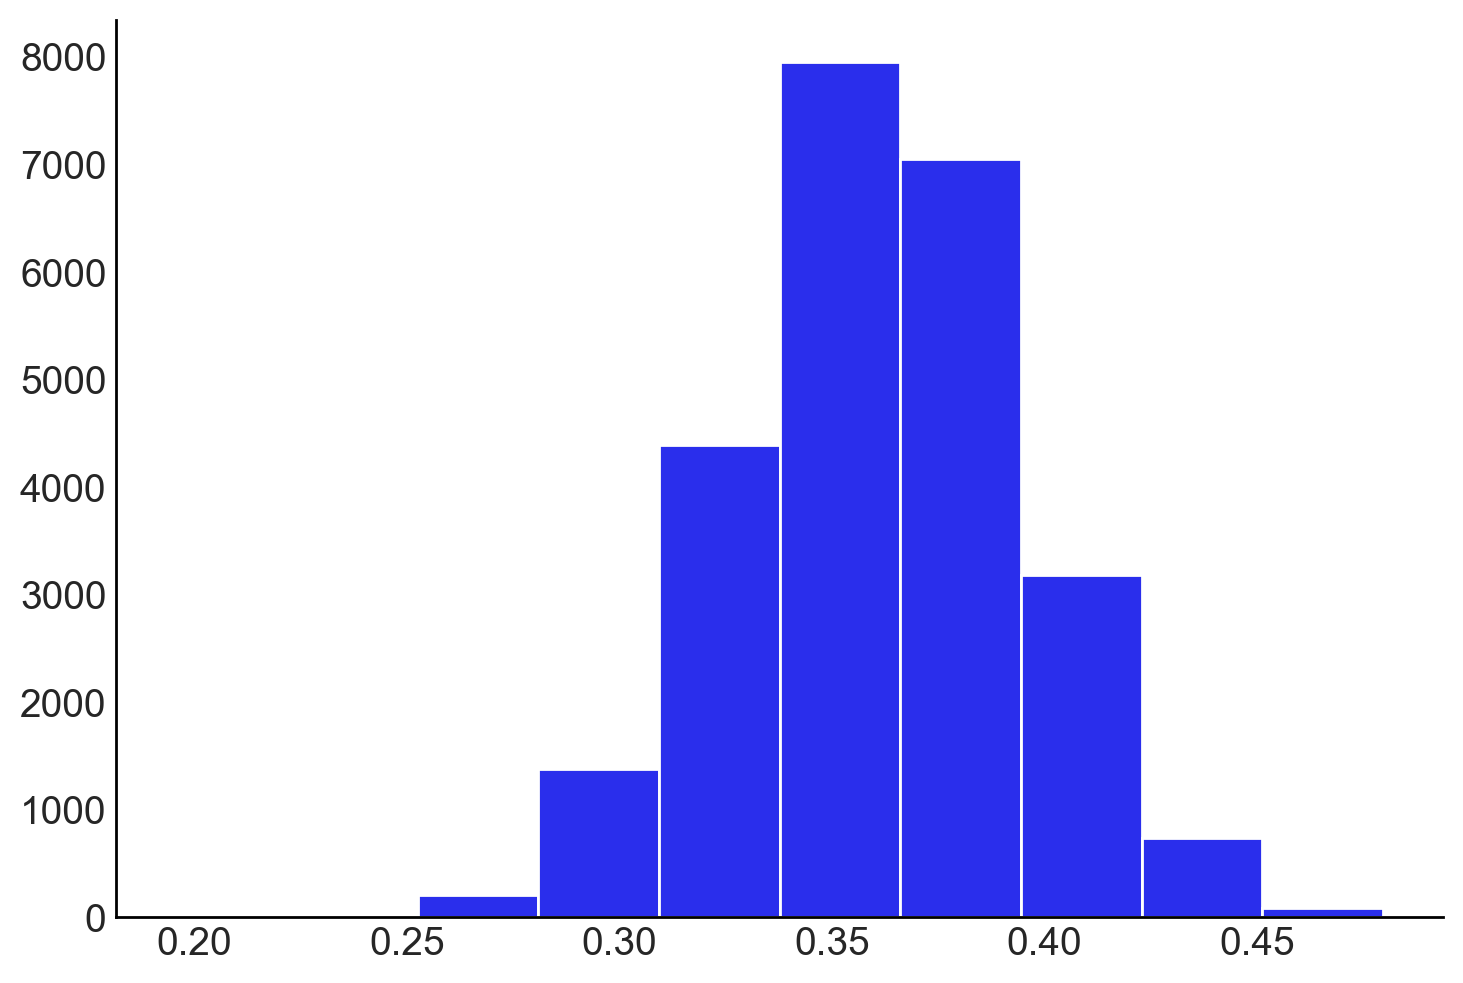

In [23]:
def q025(x):
    return x.quantile(.025)

def q975(x):
    return x.quantile(.975)

def q005(x):
    return x.quantile(.005)

def q995(x):
    return x.quantile(.995)

print(twostage_post_samp_jit.shape)
# print(twostage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:",1)
print(twostage_post_samp_jit.agg(['mean','std','median',q005,q025, q975, q995,'min','max']))


plt.hist(twostage_post_samp_jit["alpha_2"])
# plt.scatter(twostage_post_samp["alpha_2"],twostage_post_samp["alpha_3"])

# TODO: check what is going on in here... we obtain weird results for alpha_2

In [24]:
# Three-stage: for each A* and A|A* param, sample one A*, and sample one (or more) outcome models
def threestage_estimator(MCMC_obj, net_post_samples, Y, Z, X, n, i):

    # sample network
    curr_Astar = triu_to_mat(net_post_samples[i,], n)
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i),Y=Y,Z=Z,X=X,A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()

    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)


def threestage_jj(triu_post_samp, Y, Z, X, i):
    # sample network
    # curr_Astar = triu_to_mat(triu_post_samp, NN)
    curr_Astar = Triu_to_mat(triu_post_samp)
    # Run MCMC
    curr_posterior_samples = get_samples(random.PRNGKey(i), Y, Z, X, curr_Astar)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
     
kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
mcmc_network_pred = MCMC(kernel_outcome, num_warmup=1000, num_samples=100,num_chains=2, progress_bar=False)
Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 3000)
K = 1000
i_range = np.random.choice(a = range(Astar_post_shape[0]), size = K, replace = False)

# print("starting parallel")
# start = time.time()
# threestage_post_samp = Parallel(n_jobs=8)(delayed(threestage_estimator)(mcmc_network_pred, post_predictive["triu_star"], Y, Z,x, n,i) for i in tqdm(i_range))
# threestage_post_samp = pd.concat(threestage_post_samp,axis=0)
# print(threestage_post_samp)
# print("No JIT time: ", time.time() - start)


start = time.time()
threestage_post_samp_jit = pd.DataFrame()
for i in tqdm(i_range):
# for i in tqdm(range(Astar_post_shape[0])):
# for i in tqdm(range(Astar_post_shape[0])):
    cur_res = threestage_jj(post_predictive["triu_star"][i,], Y, Z, x, i)
    threestage_post_samp_jit = pd.concat([threestage_post_samp_jit, cur_res])    
print(threestage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)




100%|██████████| 1000/1000 [00:31<00:00, 31.97it/s]

      iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
0    11787  1.374905  0.050283  2.734554  0.387896 -0.250438
1    11787  1.297095 -0.081531  2.629050  0.362130 -0.221491
2    11787  1.409070 -0.138776  2.476375  0.398109 -0.201467
3    11787  1.403213 -0.247264  2.895171  0.425408 -0.278221
4    11787  1.413157 -0.284368  2.875163  0.387729 -0.282597
..     ...       ...       ...       ...       ...       ...
495   6859  1.556090 -0.191306  2.957487  0.386870 -0.226519
496   6859  1.473819 -0.141219  2.947261  0.387389 -0.252791
497   6859  1.438961 -0.130334  2.953125  0.367067 -0.263978
498   6859  1.423063 -0.015637  2.915117  0.355370 -0.226928
499   6859  1.410579  0.001055  2.960651  0.333121 -0.246352

[500000 rows x 6 columns]
with JIT (non parallel) takes:  31.300533056259155


(500000, 6)
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1
                iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
mean     8051.095000  1.408030 -0.269146  2.865530  0.358745 -0.250836
std      4575.456613  0.065732  0.196477  0.211548  0.065156  0.030828
median   7981.000000  1.406160 -0.266064  2.865695  0.356274 -0.250799
q005      111.975000  1.249448 -0.795883  2.316592  0.224436 -0.330734
q025      408.775000  1.284282 -0.663356  2.450118  0.246415 -0.311389
q975    15714.075000  1.542164  0.106995  3.279150  0.486922 -0.190482
q995    15914.075000  1.588405  0.218221  3.411671  0.521745 -0.171532
min         6.000000  1.123582 -1.193627  1.852562  0.160718 -0.402456
max     15996.000000  1.752687  0.647494  4.001151  0.637983 -0.113745


(array([4.90000e+02, 2.11840e+04, 9.36940e+04, 1.22426e+05, 1.21007e+05,
        9.21760e+04, 4.00280e+04, 8.17200e+03, 7.78000e+02, 4.50000e+01]),
 array([0.16071782, 0.20844436, 0.2561709 , 0.30389744, 0.35162398,
        0.39935052, 0.44707704, 0.49480358, 0.54253012, 0.59025669,
        0.6379832 ]),
 <BarContainer object of 10 artists>)

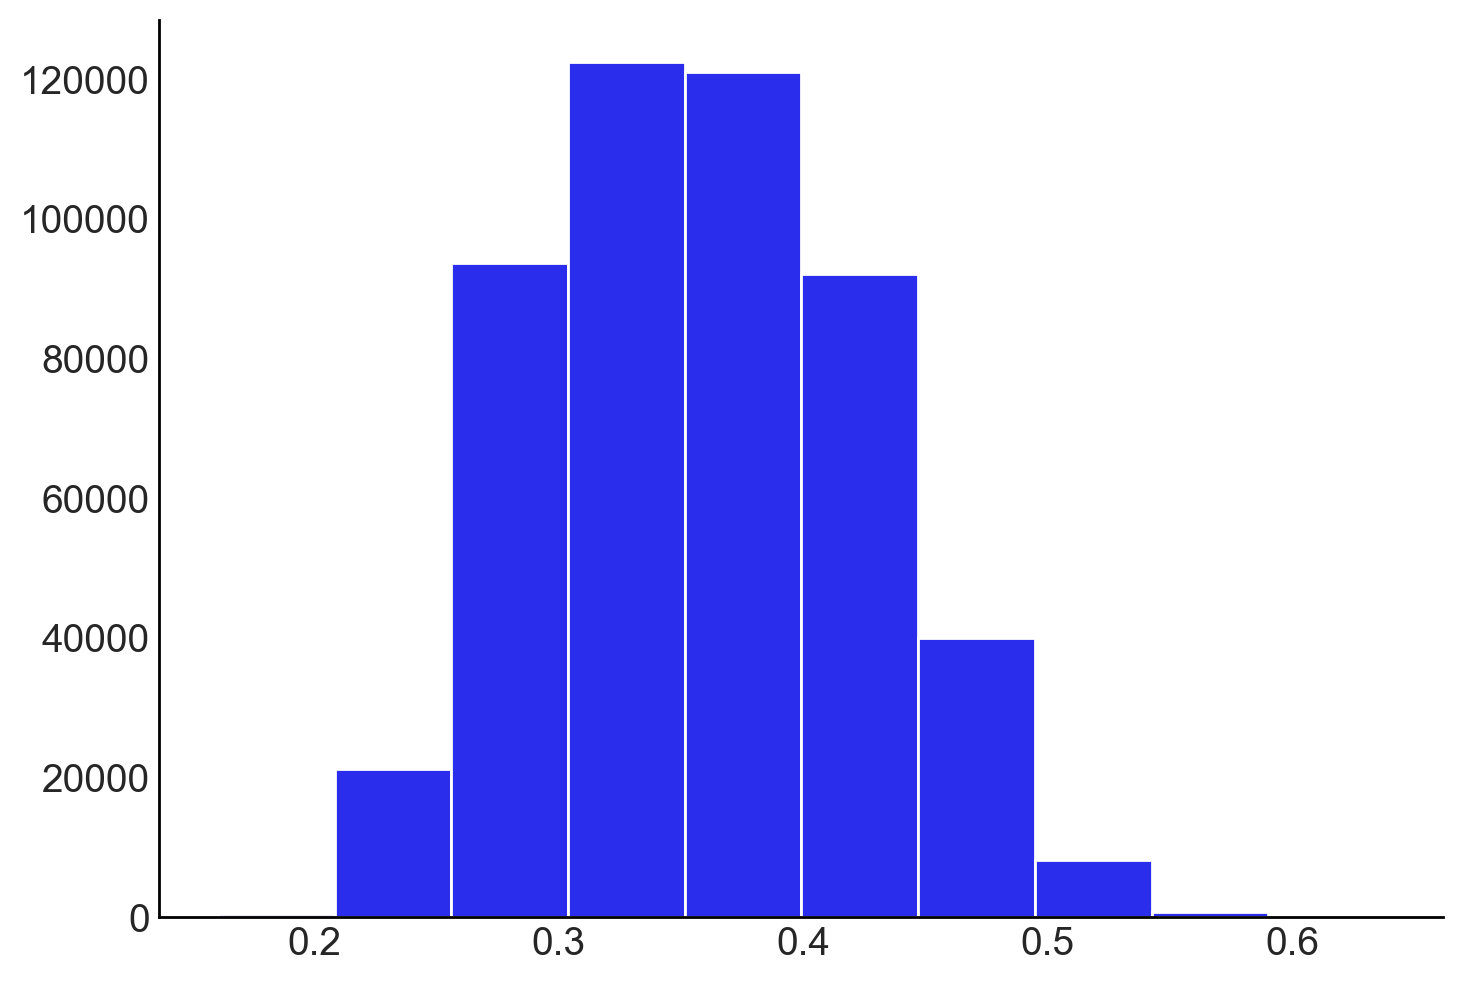

In [25]:
print(threestage_post_samp_jit.shape)
# print(threestage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:", 1)
threestage_post_samp_agg = threestage_post_samp_jit.agg(['mean','std','median',q005,q025, q975,q995,'min','max'])
print(threestage_post_samp_agg)

plt.hist(threestage_post_samp_jit["alpha_2"])

In [26]:
print(threestage_post_samp_agg["alpha_2"]["mean"])
dict_3S = threestage_post_samp_agg["alpha_2"].to_dict()
print(dict_3S)
dict_3S["var_MI"] = 3
print(dict_3S)
dict_3S = {k : dict_3S[k] for k in ["mean","median","var_MI","q025","q975","min","max"]}
print(pd.DataFrame(dict_3S, index = [0]))


0.3587450683116913
{'mean': 0.3587450683116913, 'std': 0.06515634804964066, 'median': 0.35627442598342896, 'q005': 0.22443628892302514, 'q025': 0.24641473554074764, 'q975': 0.4869223445653915, 'q995': 0.5217447087168694, 'min': 0.16071781516075134, 'max': 0.6379832029342651}
{'mean': 0.3587450683116913, 'std': 0.06515634804964066, 'median': 0.35627442598342896, 'q005': 0.22443628892302514, 'q025': 0.24641473554074764, 'q975': 0.4869223445653915, 'q995': 0.5217447087168694, 'min': 0.16071781516075134, 'max': 0.6379832029342651, 'var_MI': 3}
       mean    median  var_MI      q025      q975       min       max
0  0.358745  0.356274       3  0.246415  0.486922  0.160718  0.637983


In [27]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



VB:  0.003388933710627131 VW:  0.00086151966  Total var:  0.004253842300947502  Naive var:  0.0042453413


In [28]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).
def onestage_estimator(net_post_samples, Z, n, i_range):
    
    deg_list = []
    # sum_expos_list = []
    expos_list = []
    
    for i in i_range:
        # sample network
        # curr_Astar = triu_to_mat(net_post_samples[i,], n)
        curr_Astar = Triu_to_mat(net_post_samples[i,])
        
        # save statistics
        # c_deg = np.sum(curr_Astar,1)
        # c_sum_expos = np.dot(curr_Astar, Z)
        # c_expos = np.where(np.equal(c_deg,0),0,c_sum_expos/c_deg)
        
        deg_list.append([np.sum(curr_Astar,1)])
        expos_list.append([np.dot(curr_Astar, Z)])
        
        # deg_list.append([c_deg])
        # sum_expos_list.append([c_sum_expos])
        # expos_list.append([c_expos])
    
    return {'deg' : deg_list,
            # 'sum_expos' : sum_expos_list,
            'expos' : expos_list}
        
# i_range = np.random.randint(low=0, high=post_predictive["triu_star"].shape[0],size =5000)
start = time.time()
onestage_net_stat = onestage_estimator(post_predictive["triu_star"], Z, n, range(post_predictive["triu_star"].shape[0]))
print(time.time() - start)
# onestage_net_stat = Parallel(n_jobs=8)(delayed(onestage_estimator)(post_predictive["triu_star"], Z, n,i) for i in tqdm(i_range))
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=1000,num_chains=1, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 1000)


19.848330974578857


deg corr 0.9049991507187599
expos corr 0.8488422778143463
expos (hat) corr Y 0.5624271911174453
expos (true) corr Y 0.6112175267930011


Text(0, 0.5, 'True expos')

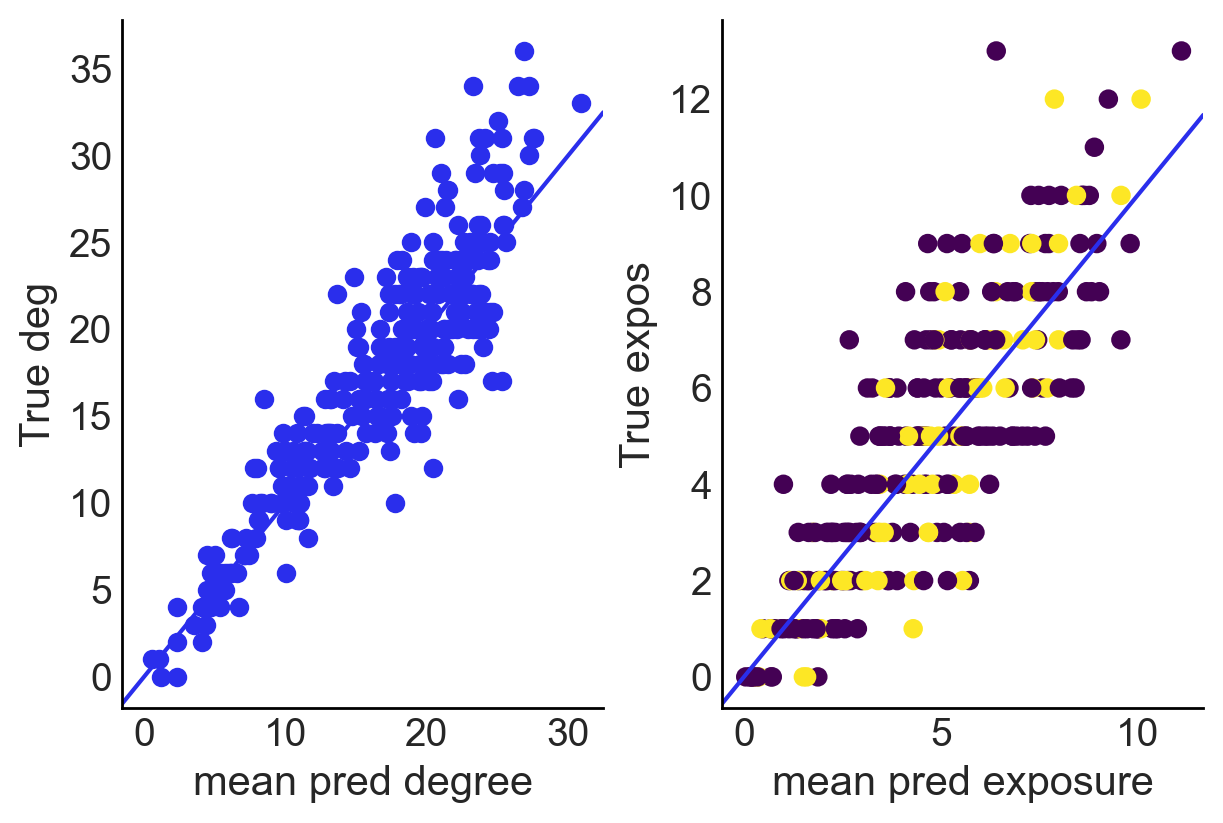

In [29]:
mean_deg = np.mean(onestage_net_stat["deg"],axis=0)
mean_expos = np.mean(onestage_net_stat["expos"],axis=0)
# mean_sum_expos = np.mean(onestage_net_stat["sum_expos"],axis=0)

print("deg corr", np.corrcoef(mean_deg,deg)[1,0])
print("expos corr", np.corrcoef(mean_expos,exposures)[1,0])
print("expos (hat) corr Y", np.corrcoef(mean_expos,Y)[1,0])
print("expos (true) corr Y", np.corrcoef(exposures,Y)[1,0])

fig, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize = (6,4))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(mean_deg, np.sum(mat,1), marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(mean_expos, exposures,c = Z+1, marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred degree")
ax2.set_xlabel("mean pred exposure")
ax1.set_ylabel("True deg")
ax2.set_ylabel("True expos")


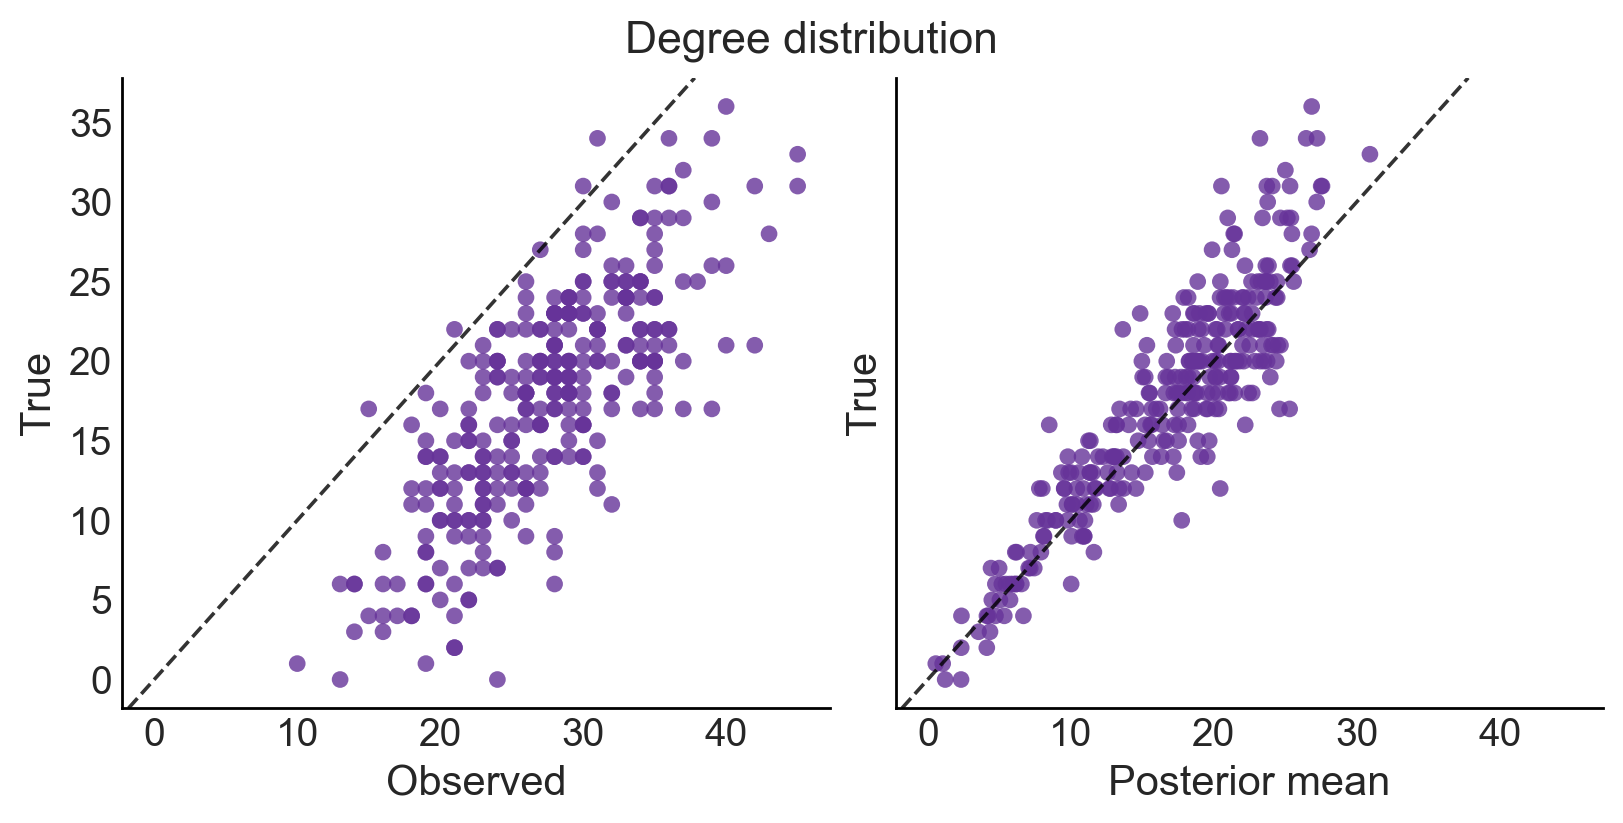

In [31]:

true_deg = np.sum(mat,1)
obs_deg = np.sum(obs_mat,1)

beige_color = '#FFFDFA'
pastel_purple_dark = (0.4, 0.2, 0.6)
# sns.set_theme(style="ticks", rc={'figure.facecolor': beige_color, 'axes.facecolor' : beige_color})
# sns.set_context("poster")


fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
# fig.patch.set_facecolor(beige_color)
# for ax in axes:
    # ax.set_facecolor(beige_color) 

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(x=obs_deg,y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax1.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(x=mean_deg, y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax2.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
ax2.set_xlabel("Posterior mean")
ax1.set_xlabel("Observed")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

fig.suptitle('Degree distribution', fontsize=16)

fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('deg_dist.png', dpi=300)

Text(0, 0.5, 'True')

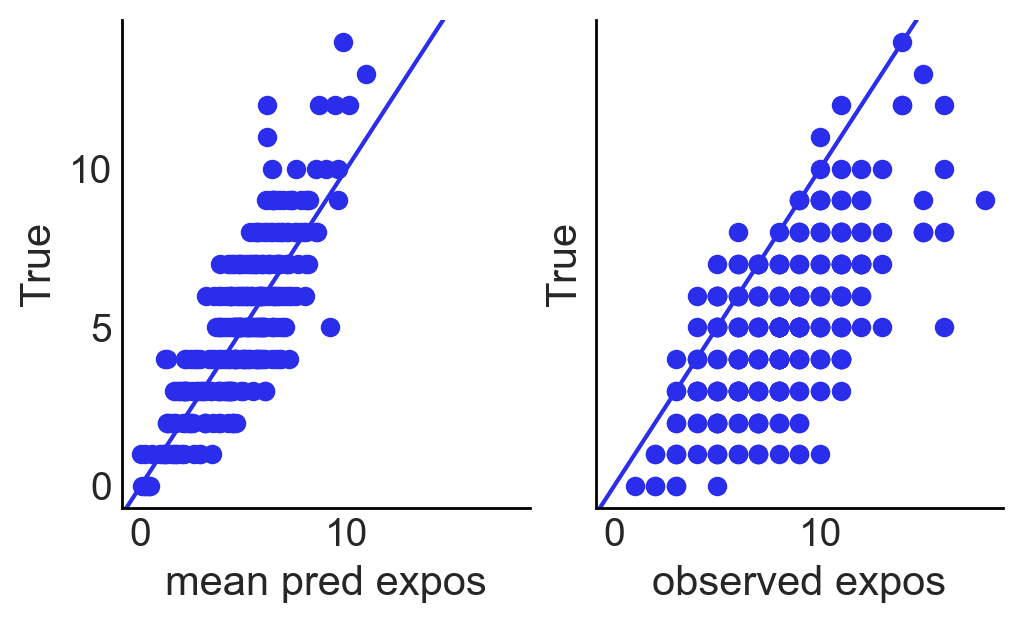

In [82]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True, figsize = (5,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
# ax1.scatter(mean_expos, exposures, c = Z, marker = 'o')
ax1.scatter(mean_expos, exposures, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.scatter(obs_exposures, exposures,c = Z, marker = 'o')
ax2.scatter(obs_exposures, exposures,marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred expos")
ax2.set_xlabel("observed expos")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

In [337]:
def outcome_stat_model(Y,Z,X,expos,n):
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # sig = numpyro.sample("sig",dist.HalfNormal(scale=5))
    sig = numpyro.sample("sig",dist.Exponential(0.5))
    # expos = jnp.dot(A,Z) / jnp.sum(A,1)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("n",n):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)

# TODO: seems like this is the best option ATM... 
# TODO: 1. check how to represent ICAR (or CAR) models (a la spatial reg) with suffiecent statistics 


In [338]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
kernel_stat_outcome = NUTS(outcome_stat_model)
mcmc_network_stat = MCMC(kernel_stat_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_stat.run(rng_key_,Y=Y,Z=Z,X=x,expos=mean_expos,n=n)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_stat.print_summary()
samples_network_stat = mcmc_network_stat.get_samples()
print(time.time() - start)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.89      0.14     -1.89     -2.12     -1.65  10287.82      1.00
  alpha[1]      3.05      0.16      3.05      2.80      3.31  13526.62      1.00
  alpha[2]      0.70      0.10      0.70      0.55      0.87  10795.87      1.00
  alpha[3]     -0.24      0.03     -0.24     -0.28     -0.20  14734.99      1.00
       sig      1.19      0.05      1.19      1.11      1.27  15103.55      1.00

Number of divergences: 0
4.517497777938843
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [339]:
# dims = {"X": ["time"], "TriU": ["time"]}
# idata_kwargs = {"dims": dims, "constant_data": {"X": x_diff, "TriU": triu_obs}}
# trace_data = az.from_numpyro(mcmc, **idata_kwargs)
# trace_data = az.from_numpyro(posterior=mcmc_network, posterior_predictive=post_predictive,)
# display(trace_data)
# az.plot_trace(trace_data, compact=True)

In [340]:
# posterior_mu = jnp.expand_dims(samples["beta0"],-1) + jnp.expand_dims(samples["beta1"],-1)*x_diff

# print(posterior_mu.shape)
# print(posterior_mu[0:5,0:5])

# fix, ax = plt.subplots(nrows=1,ncols=1, figsize = (5,5))
# ax.plot(beta[0] + beta[1]*x_diff, posterior_mu.mean(axis=0), "o")


In [341]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_triu = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_triu].set(triu) 
    return adj_mat + adj_mat.T

def model_discrete(Y, Z, X, TriU, n):
    # Network model
    beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    mu_net = beta_0 + beta_1*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    
    # temp = numpyro.sample("temp", dist.Uniform(low=0,high=1))
    
    with numpyro.plate("A* and A",triu_n):
        # logp of A* 
        triu_star = numpyro.sample("triu_star",dist.BernoulliLogits(logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=.5,logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=temp,logits=mu_net))
        # # logp of A|A*
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        # prob_misspec = jnp.where(tril_star==1, 1-gamma1, gamma0)
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
       
    # get Astar the symmetric matrix from lower triangle values `tril_var`
    Astar = numpyro.deterministic("Astar", triu_to_mat(triu_star,n))
    # Compute exposures (Astar*Z / d)
    degrees = jnp.sum(Astar,1)
    # num_expos = jnp.dot(Astar,Z)
    # expos = numpyro.deterministic("expos", jnp.where(degress==0,0,num_expos/degrees))
    expos = numpyro.deterministic("expos", jnp.nan_to_num(jnp.dot(Astar,Z)/jnp.sum(Astar,1),nan=0.0))
       
    
    # Outcome model
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    sig = numpyro.sample("sig", dist.Exponential(0.5))
    mu = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*degrees
    with numpyro.plate("n",n):
        numpyro.sample("Y",dist.Normal(mu,sig),obs=Y)
        
    
        


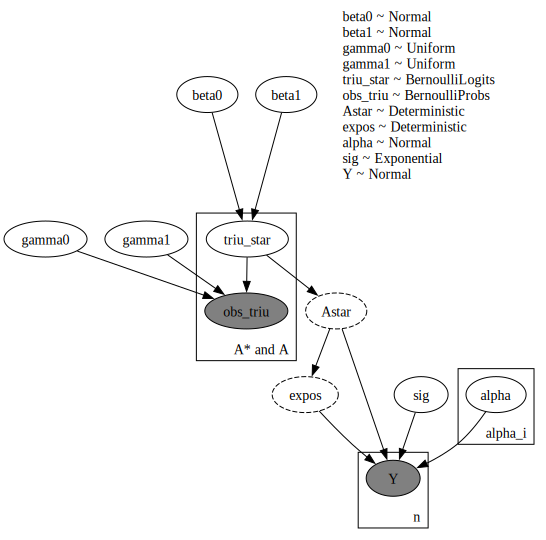

In [342]:
numpyro.render_model(model_discrete, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)


In [343]:
# # Sample from relaxed model
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# # kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model_relaxed)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc.print_summary()
# samples = mcmc.get_samples()
# print(time.time() - start)

In [344]:
print("beta 0:", beta[0], "beta1:", beta[1], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)


beta 0: -2.5 beta1: -0.5 gamma0: 0.049999999999999996 gamma1: 0.3
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [345]:
# Sample from discrete model with mixedHMC
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.2), num_discrete_updates=tril_dim//6)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=1000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [346]:
# Sample from discrete model with NwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [347]:
# Sample from discrete model with HwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(HMC(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)